In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
!pip install git+https://github.com/pytorch/tnt.git@master
!pip install tqdm
  
from torchnet.engine import Engine
import torchnet as tnt
from tqdm import tqdm, tqdm_notebook

  Cloning https://github.com/pytorch/tnt.git (to master) to /tmp/pip-bkd7yvcq-build


In [0]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

from sklearn import metrics
from sklearn.model_selection import train_test_split

In [0]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

EPOCHS_TO_TRAIN = 10

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]


sns.set(style='whitegrid', palette='colorblind', font_scale=1.5)
# sns.set(style='whitegrid', font_scale=1.5)

sns.color_palette(flatui)

rcParams['figure.figsize'] = 12, 8

In [0]:
!mkdir data

In [8]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip && unzip ml-latest-small -d data/

--2018-02-11 10:28:43--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 918269 (897K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 896.75K  3.12MB/s    in 0.3s    

2018-02-11 10:28:43 (3.12 MB/s) - ‘ml-latest-small.zip’ saved [918269/918269]

Archive:  ml-latest-small.zip
   creating: data/ml-latest-small/
  inflating: data/ml-latest-small/links.csv  
  inflating: data/ml-latest-small/movies.csv  
  inflating: data/ml-latest-small/ratings.csv  
  inflating: data/ml-latest-small/README.txt  
  inflating: data/ml-latest-small/tags.csv  


# Data loading

Data comes from [Grouplens](https://grouplens.org/datasets/movielens/).

> This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100004 ratings and 1296 tag applications across 9125 movies. These data were created by 671 users between January 09, 1995 and October 16, 2016. This dataset was generated on October 17, 2016.

> Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

In [0]:
PATH = "data/ml-latest-small/"

In [8]:
!ls {PATH}/

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


In [9]:
ratings = pd.read_csv(PATH + 'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [10]:
movies = pd.read_csv(PATH + 'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Exploration

In [11]:
movies.shape

(9125, 3)

In [12]:
ratings.shape

(100004, 4)

In [13]:
movies.isnull().values.any()

False

In [14]:
ratings.isnull().values.any()

False

In [15]:
movies['genres'] = movies['genres'].str.split('|')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [16]:
animations = movies[movies.genres.map(lambda x: 'Animation' in x)]
print(f'{len(animations.index)} animation movies')

447 animation movies


In [0]:
movies['genre_count'] = movies.genres.apply(lambda x: len(x))

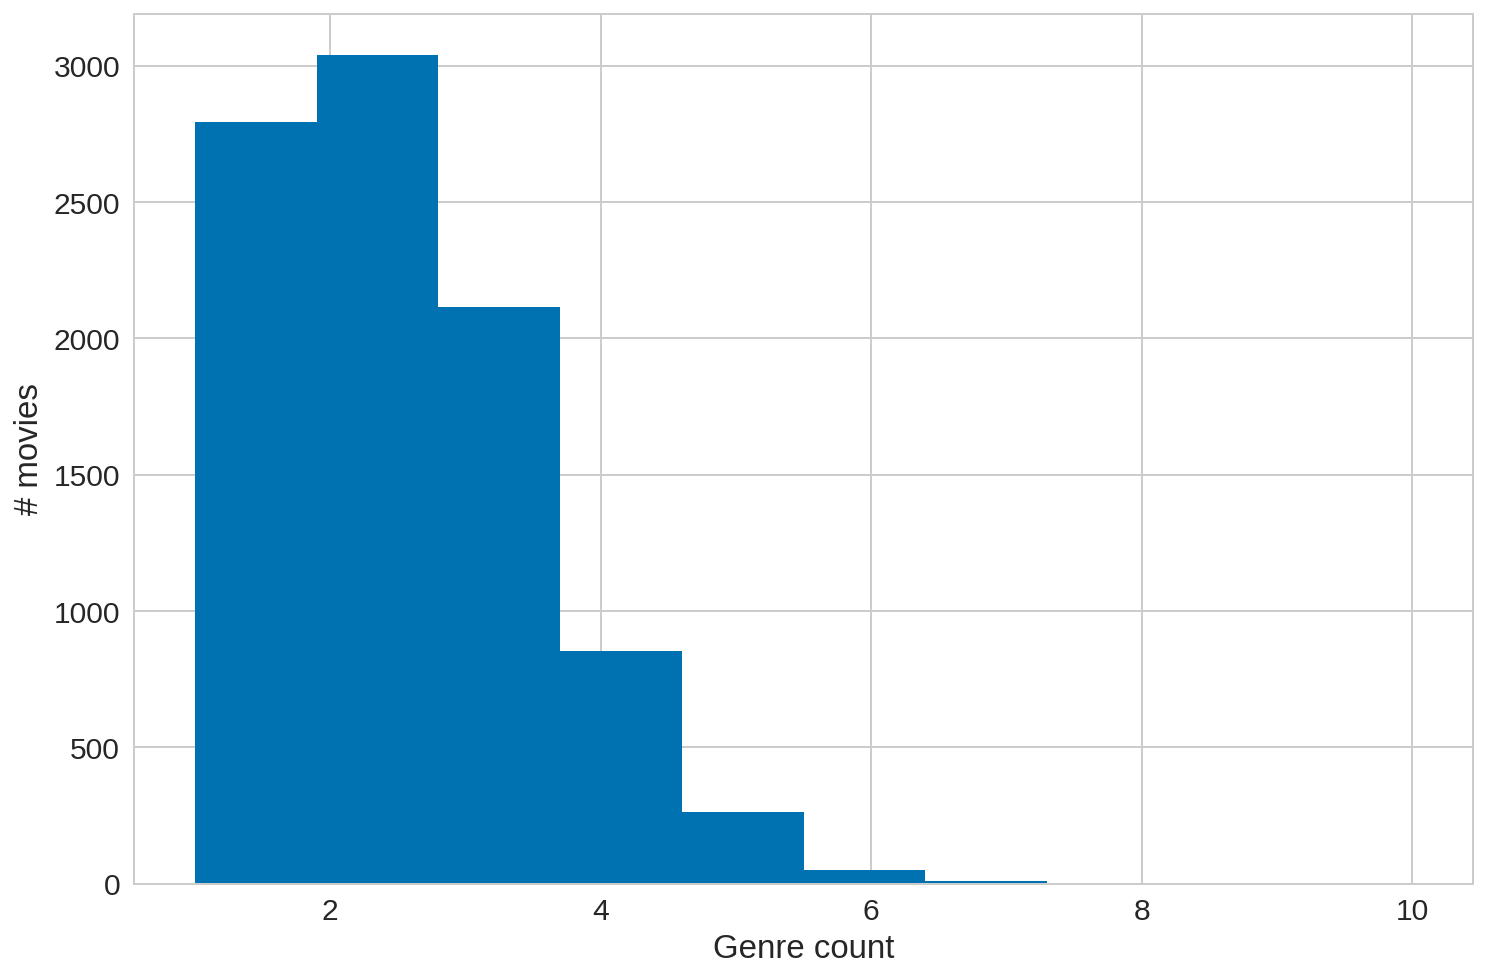

In [18]:
movies.genre_count \
  .plot(kind="hist") \
  .set(xlabel='Genre count', ylabel='# movies');

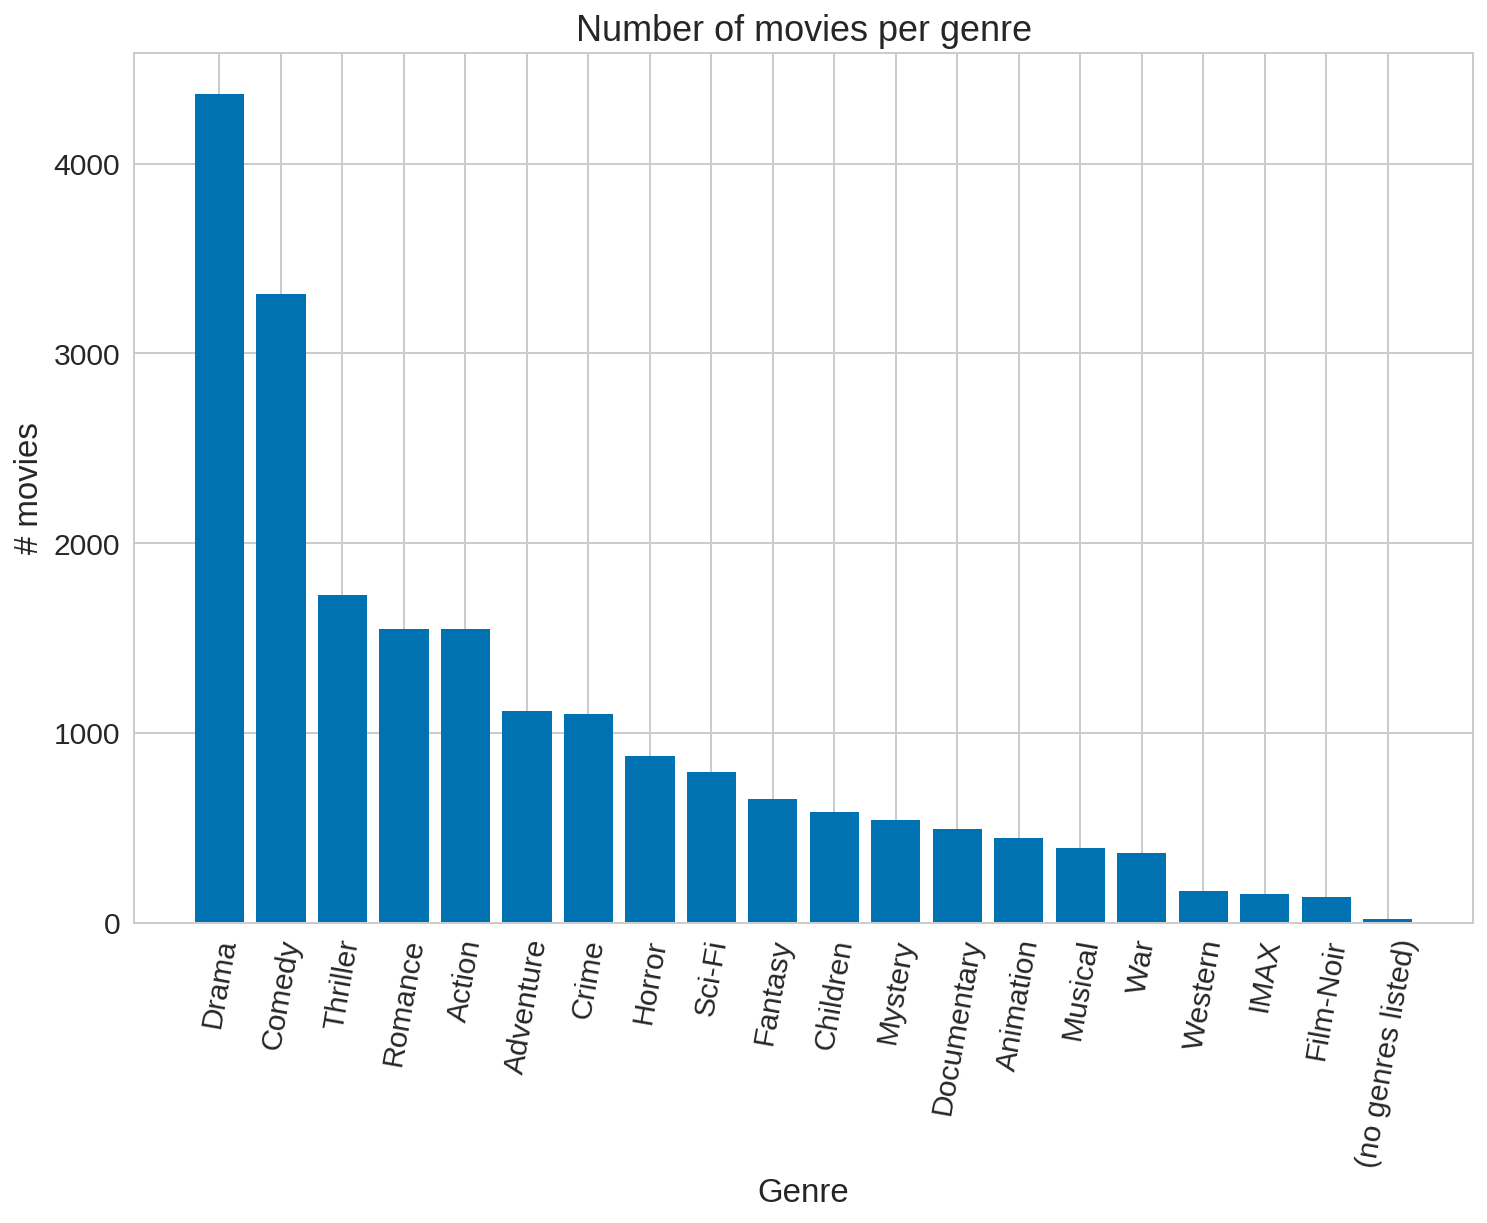

In [19]:
from collections import Counter

flattened_genres = [item for sublist in movies.genres for item in sublist]

genre_dict = dict(Counter(flattened_genres).most_common())

x = list(range(len(genre_dict)))

fig, ax = plt.subplots()

plt.xticks(x, genre_dict.keys(), rotation=80)
ax.bar(x, genre_dict.values())
ax.set_title("Number of movies per genre")
ax.set_xlabel("Genre")
ax.set_ylabel("# movies")
plt.plot();

In [0]:
release_years = movies.title.str.extract("\\(([0-9 \\-]*)\\)$", expand=False)

In [21]:
release_years[release_years.str.len() > 4]

8505        2007-
8507    1975-1979
Name: title, dtype: object

In [0]:
release_years[8505] = "2007"
release_years[8507] = "1975"

In [23]:
mask = release_years.isnull().values
release_years[mask]

7867    NaN
7984    NaN
8048    NaN
8399    NaN
8567    NaN
9017    NaN
9063    NaN
9118    NaN
9124    NaN
Name: title, dtype: object

In [24]:
movies.title[9063]

'The Lovers and the Despot'

In [0]:
movies["year"] = pd.to_numeric(release_years).fillna(-1).astype(np.int32)

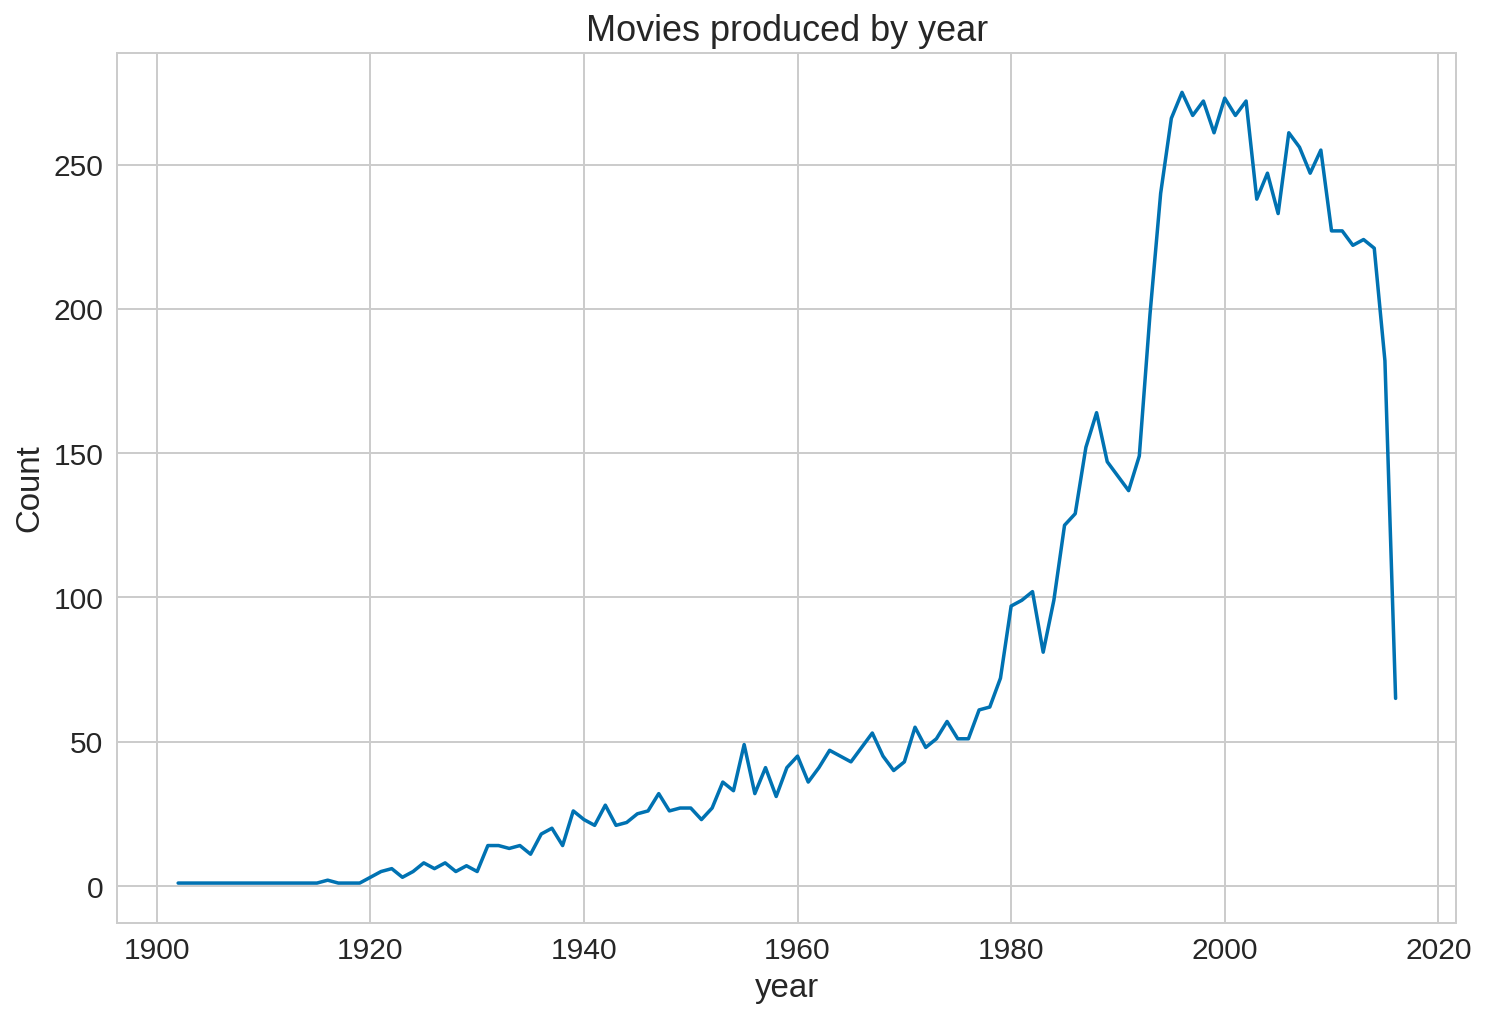

In [26]:
movies[movies.year > 0].groupby("year").count()["title"] \
  .plot(title="Movies produced by year") \
  .set(ylabel="Count");

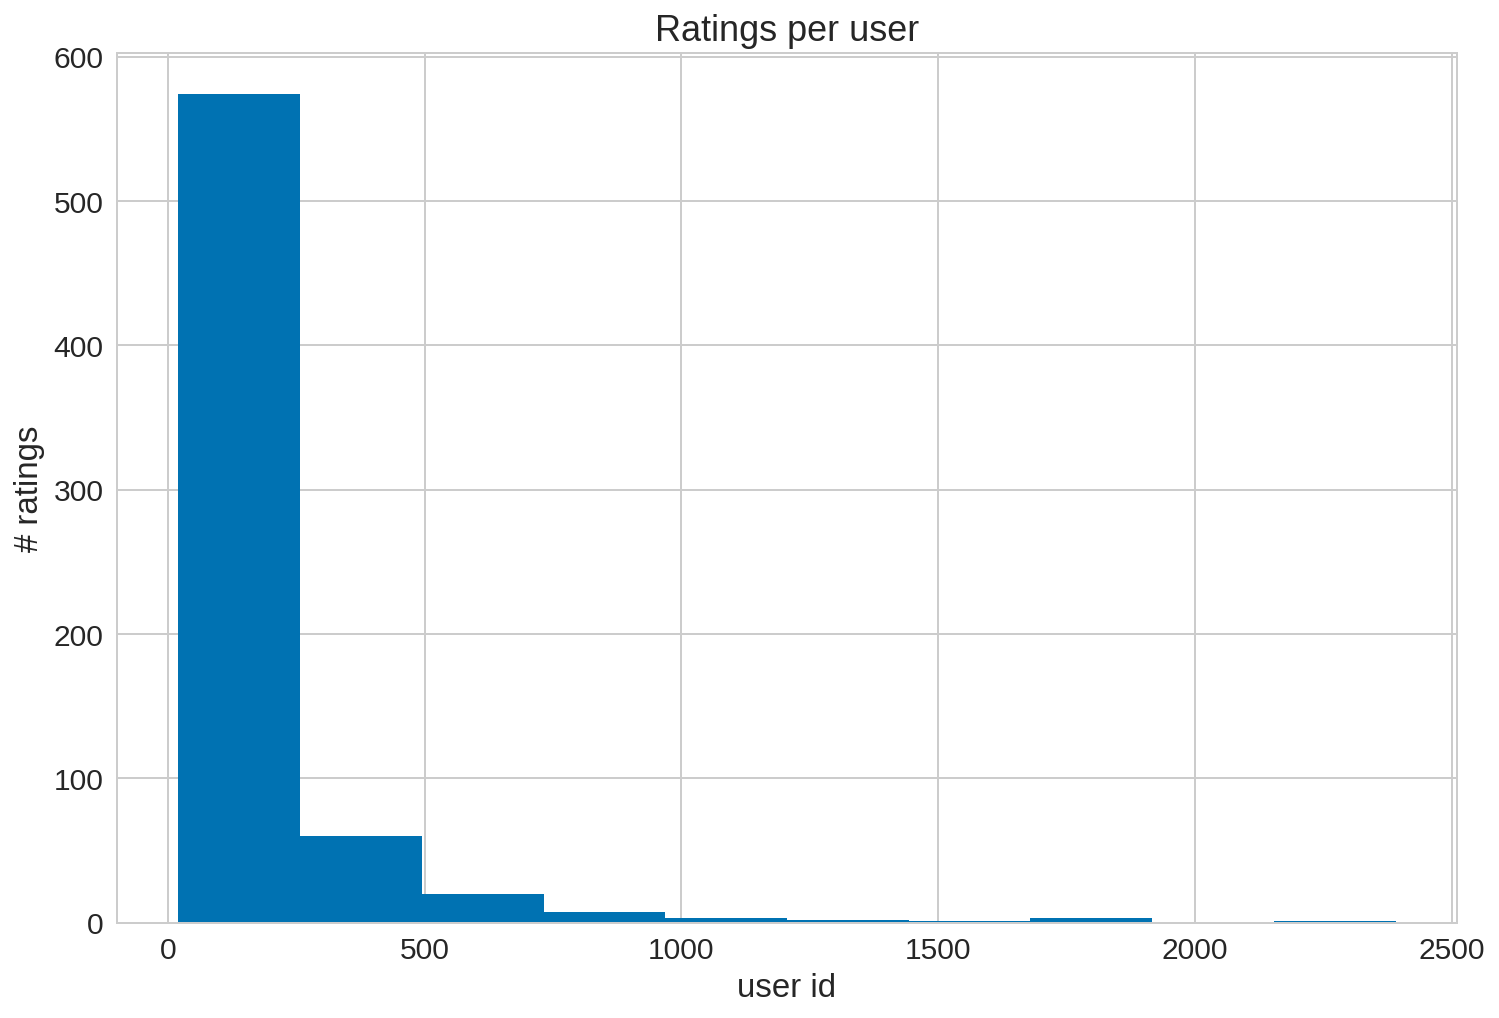

In [27]:
ratings.groupby("userId").count()["rating"] \
  .sort_values(ascending=False) \
  .plot(kind="hist", title="Ratings per user") \
  .set(xlabel="user id", ylabel="# ratings");

# One big table

In [0]:
movielens = pd.merge(movies, ratings)

In [29]:
movielens.head()

,movieId,title,genres,genre_count,year,userId,rating,timestamp
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,1995,7,3.0,851866703
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,1995,9,4.0,938629179
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,1995,13,5.0,1331380058
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,1995,15,2.0,997938310
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,1995,19,3.0,855190091


# Which movies are most rated?

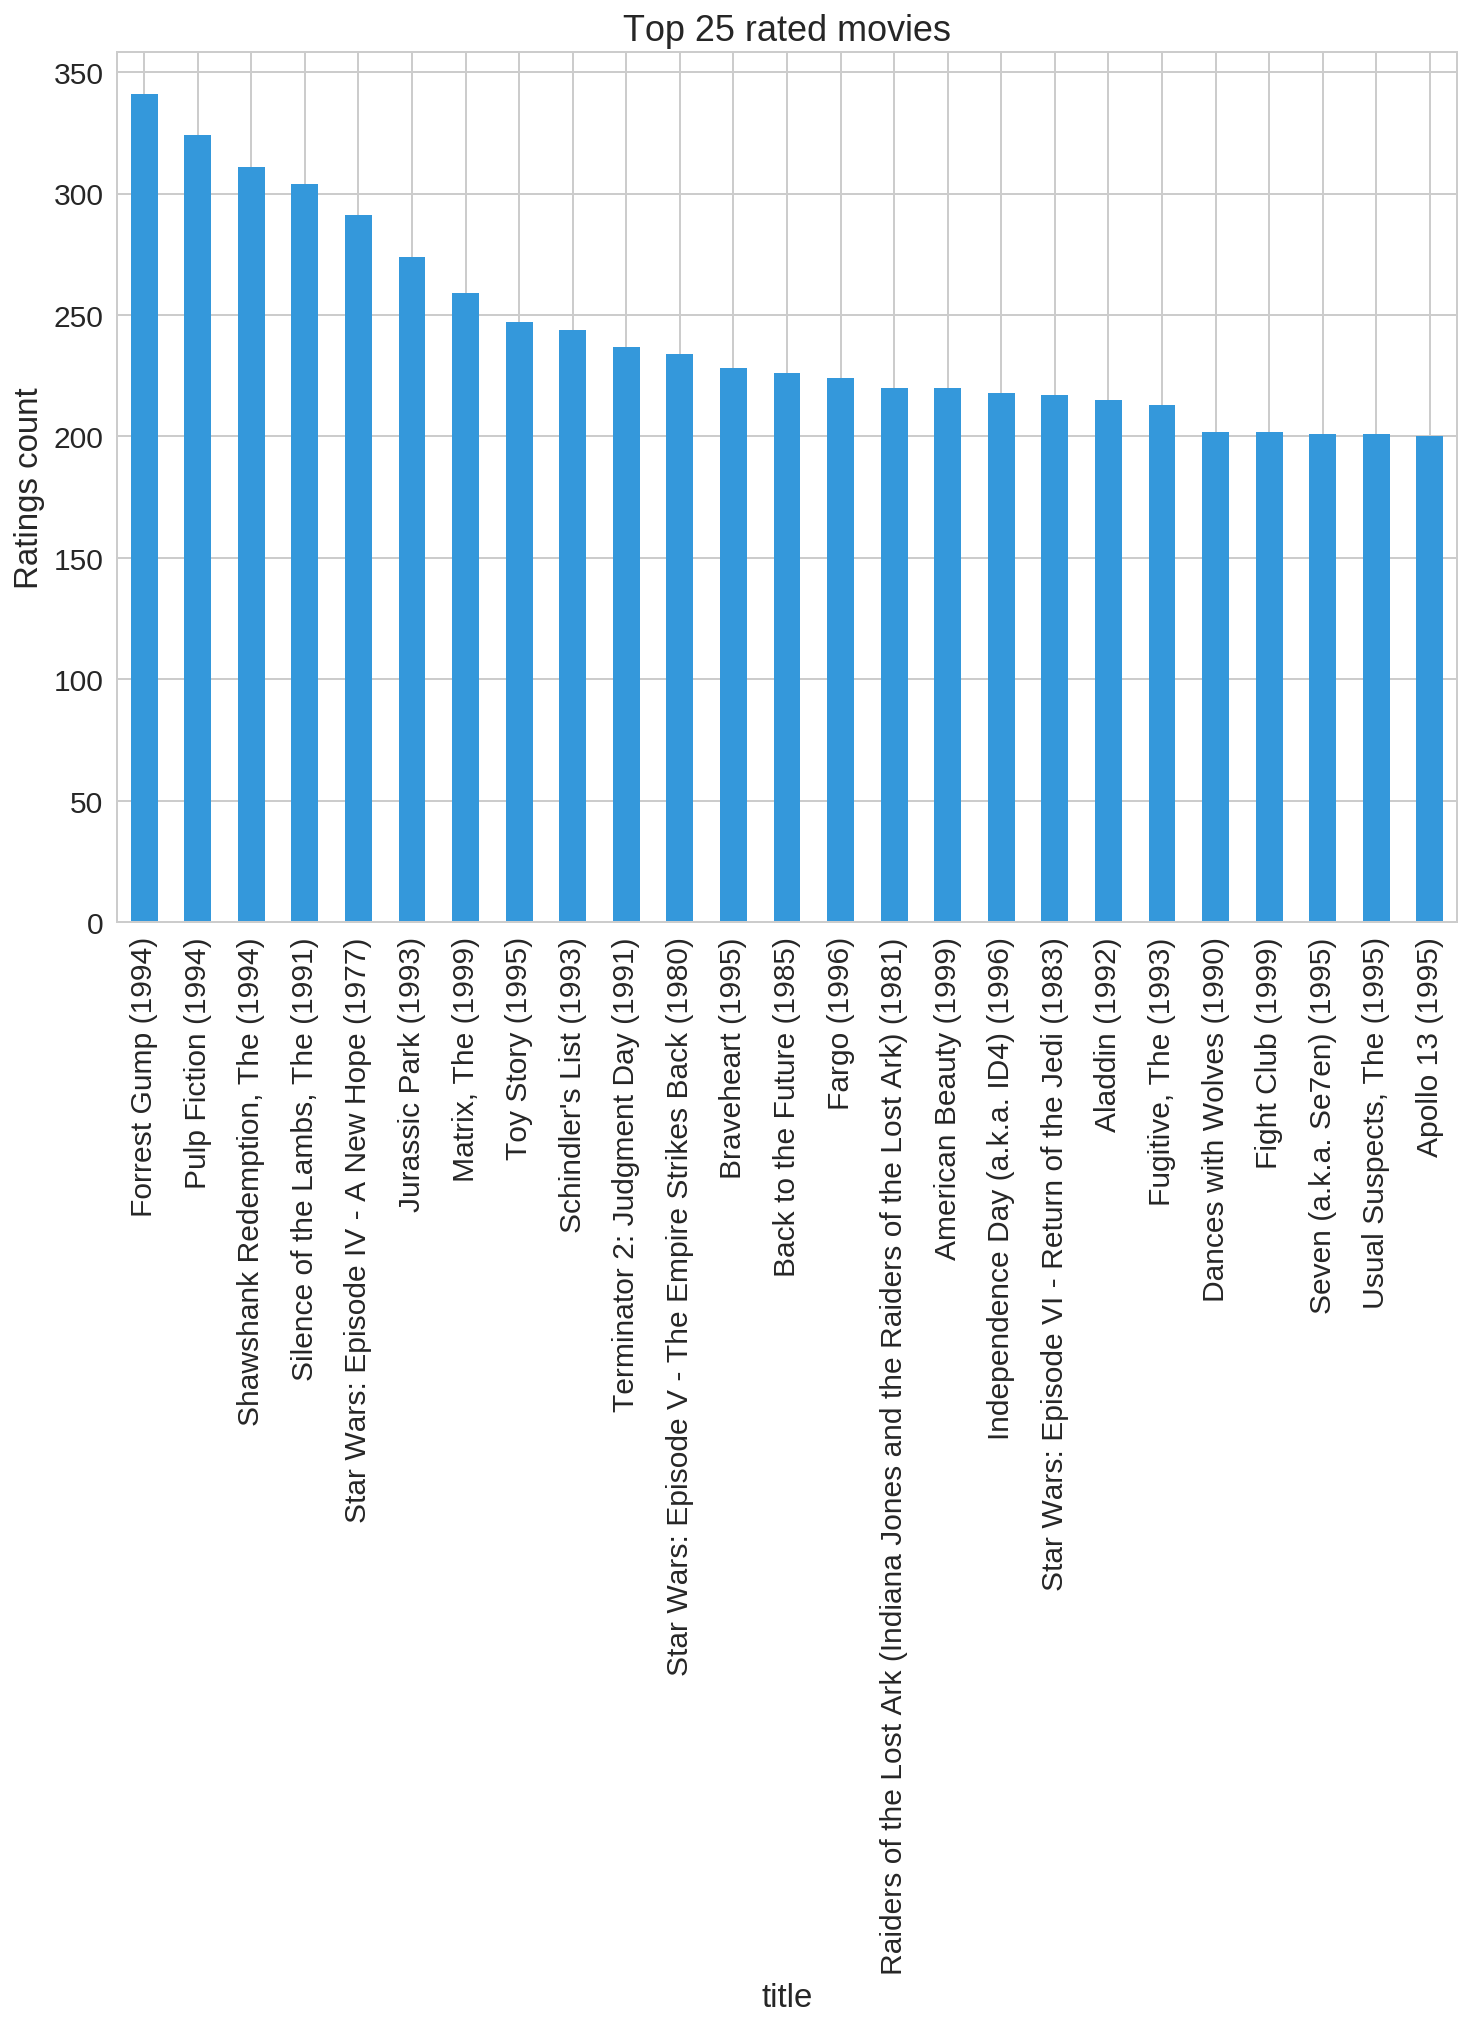

In [30]:
most_rated=movielens.groupby('title').size().sort_values(ascending=False)[:25]

most_rated.plot(kind="bar", title="Top 25 rated movies", label="count", color=flatui[1]) \
  .set(ylabel="Ratings count");

# Which are the highest rated movies?

In [31]:
movie_stat = movielens.groupby('title').agg({'rating': [np.size,np.mean]})
movie_stat.sort_values([('rating','mean')],ascending=False).head()

rating     
                                                     size mean
title                                                         
Ivan Vasilievich: Back to the Future (Ivan Vasi...    1.0  5.0
Alien Escape (1995)                                   1.0  5.0
Boiling Point (1993)                                  1.0  5.0
Bone Tomahawk (2015)                                  1.0  5.0
Borgman (2013)                                        1.0  5.0

In [32]:
most100= movie_stat['rating']['size'] >= 100
most_rated = movie_stat[most100].sort_values([('rating', 'mean')], ascending=False)
most_rated.head()

rating          
                                   size      mean
title                                            
Godfather, The (1972)             200.0  4.487500
Shawshank Redemption, The (1994)  311.0  4.487138
Godfather: Part II, The (1974)    135.0  4.385185
Usual Suspects, The (1995)        201.0  4.370647
Schindler's List (1993)           244.0  4.303279

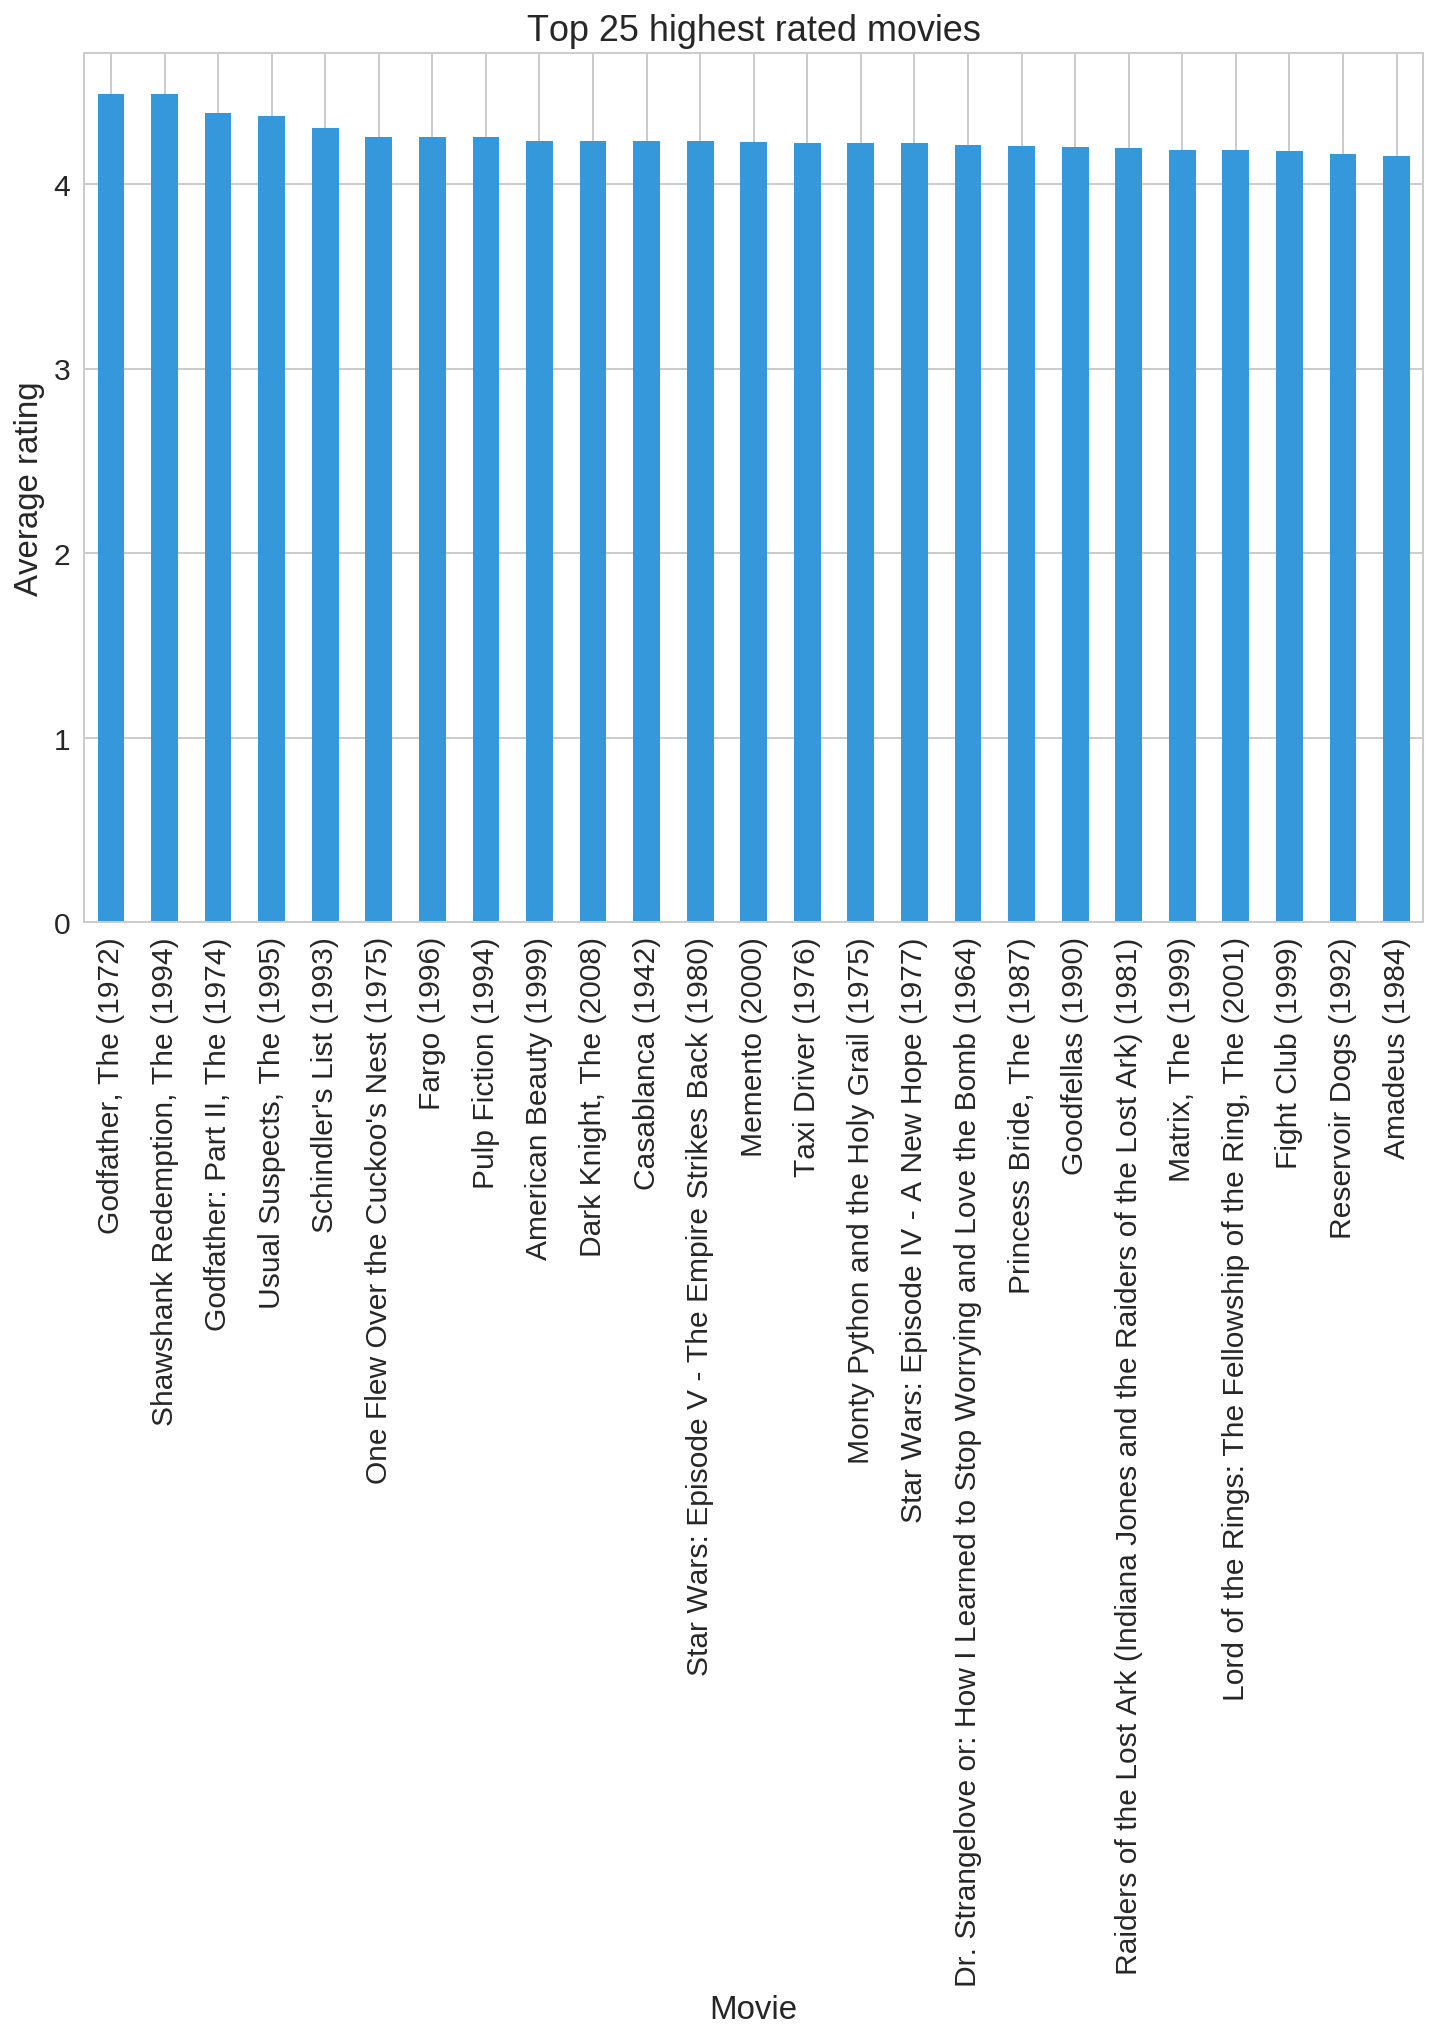

In [33]:
most_rated['rating']['mean'].sort_values(ascending=False)[:25] \
  .plot(kind="bar", color=flatui[1], title="Top 25 highest rated movies") \
  .set(xlabel="Movie", ylabel="Average rating");

# What ratings movies receive?

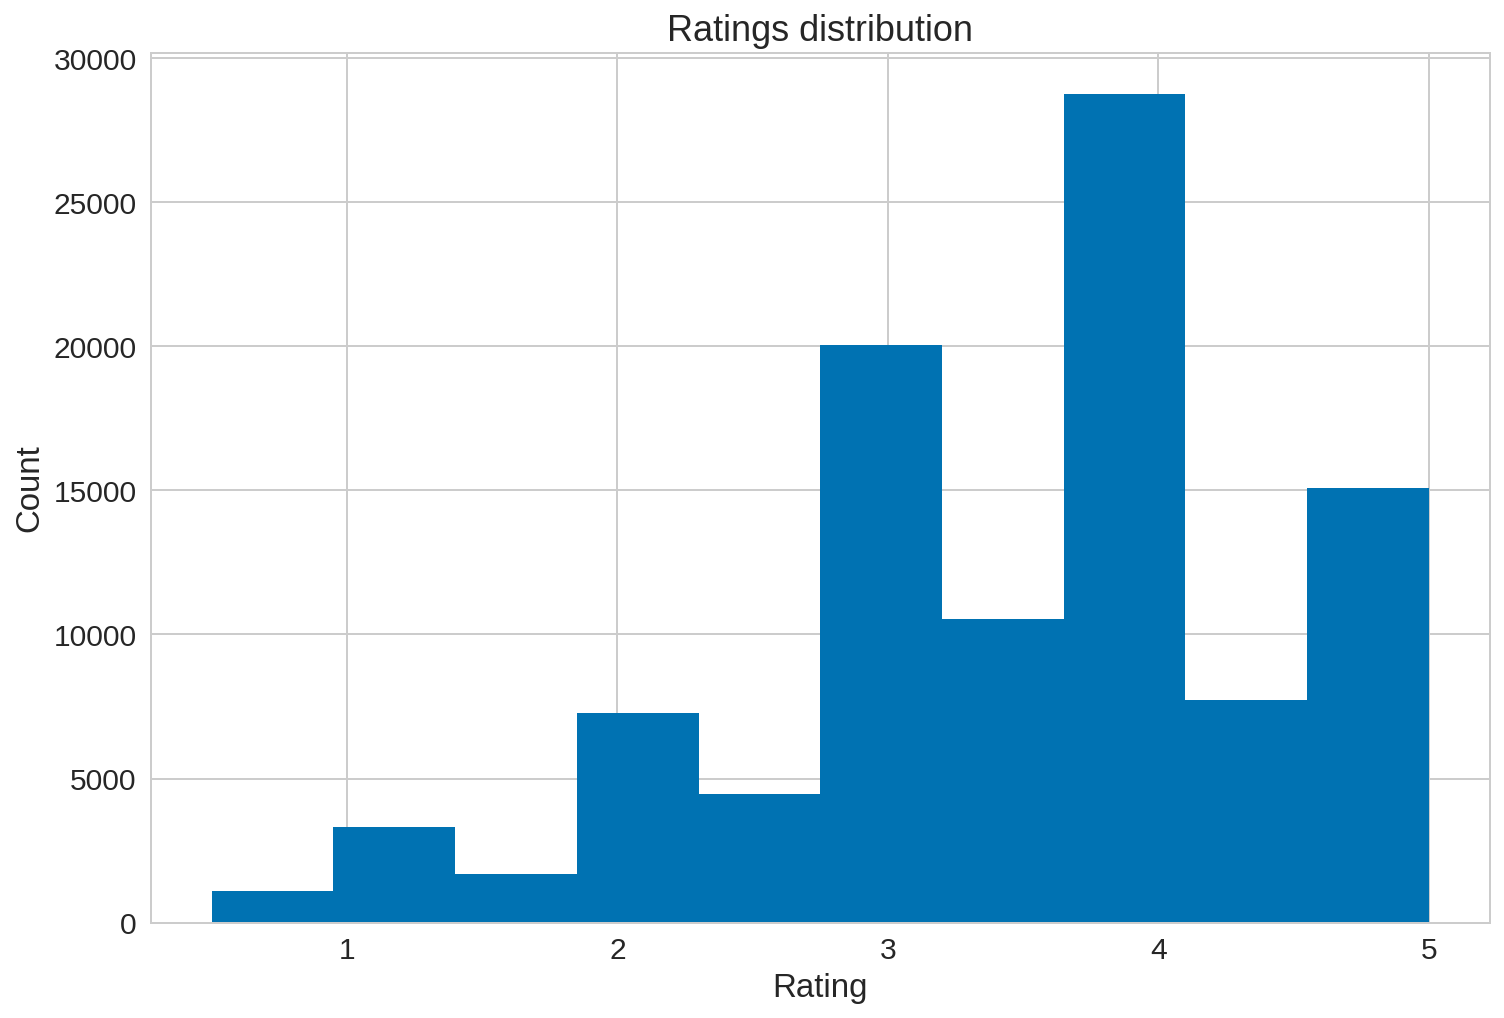

In [34]:
ratings.rating.plot(kind="hist", title="Ratings distribution") \
  .set(xlabel="Rating", ylabel="Count");

# Data transformation

In [0]:
u_uniq = ratings.userId.unique()
user2idx = {o : i for i, o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o : i for i, o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [36]:
print(n_users, n_movies)

671 9066


In [37]:
min_rating, max_rating = ratings.rating.min(), ratings.rating.max()
min_rating, max_rating

(0.5, 5.0)

In [0]:
X = ratings.drop(['rating', 'timestamp'], axis=1)
y = ratings['rating'].astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [39]:
print(X_train.shape, X_test.shape)

(80003, 2) (20001, 2)


# Model

In [0]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingNet(nn.Module):
  
    def __init__(self, n_users, n_movies, n_factors, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [0]:
n_factors = 50
wd= 1e-5
lr = 1e-3
model = EmbeddingNet(n_users, n_movies, n_factors).cuda()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [0]:
engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()

In [0]:
train_loader = tnt.dataset.TensorDataset([
    torch.from_numpy(X_train.values), 
    torch.from_numpy(y_train.values)
]).parallel(batch_size=64)

In [0]:
test_loader = tnt.dataset.TensorDataset([
    torch.from_numpy(X_test.values), 
    torch.from_numpy(y_test.values)
]).parallel(batch_size=64)

In [45]:
model

EmbeddingNet(
  (u): Embedding(671, 50)
  (m): Embedding(9066, 50)
  (lin1): Linear(in_features=100, out_features=10)
  (lin2): Linear(in_features=10, out_features=1)
  (drop1): Dropout(p=0.05)
  (drop2): Dropout(p=0.5)
)

In [46]:
def on_predict(data):
  
  x, y, is_training = data

  volatile = not is_training
  
  model.train() if is_training else model.eval()

  x = Variable(x, volatile=volatile).cuda()
  y = Variable(y.float(), volatile=volatile).cuda()
  pred = model(x)
  l = F.mse_loss(pred, y)
  return l, pred

def reset_meters():
  meter_loss.reset()

def on_sample(state):
  state['sample'].append(state['train'])

def on_forward(state):
  meter_loss.add(state['loss'].data[0])

def on_start_epoch(state):
  print(f'Epoch #{state["epoch"]}')
  reset_meters()
#   state['iterator'] = tqdm(state['iterator'])

def on_end_epoch(state):
  train_loss = meter_loss.value()[0]
  reset_meters()
  engine.test(on_predict, test_loader)
  test_loss = meter_loss.value()[0]
  print('Training loss: %.4f Test loss: %.4f\n' % (train_loss, test_loss))


engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epoch

result = engine.train(on_predict, train_loader, maxepoch=10, optimizer=optimizer)

Epoch #0
Training loss: 0.9986 Test loss: 0.8132

Epoch #1
Training loss: 0.8288 Test loss: 0.7932

Epoch #2
Training loss: 0.8026 Test loss: 0.7948

Epoch #3
Training loss: 0.7732 Test loss: 0.7938

Epoch #4
Training loss: 0.7556 Test loss: 0.7944

Epoch #5
Training loss: 0.7468 Test loss: 0.7947

Epoch #6
Training loss: 0.7437 Test loss: 0.7942

Epoch #7
Training loss: 0.7397 Test loss: 0.7919

Epoch #8
Training loss: 0.7360 Test loss: 0.7977

Epoch #9
Training loss: 0.7323 Test loss: 0.8009



# Evaluation

Some benchmarks from Librec show best RMSE result of [0.91](https://www.librec.net/release/v1.3/example.html)

In [47]:
import math

rmse_error = math.sqrt(0.7909)
rmse_error

0.889325587172662

In [0]:
test_tensor = Variable(torch.from_numpy(X_test.values), volatile=True).cuda()

In [0]:
preds = model(test_tensor)
preds = preds.data.cpu().numpy().flatten()

In [0]:
_, y_ratings = test_loader.dataset.data

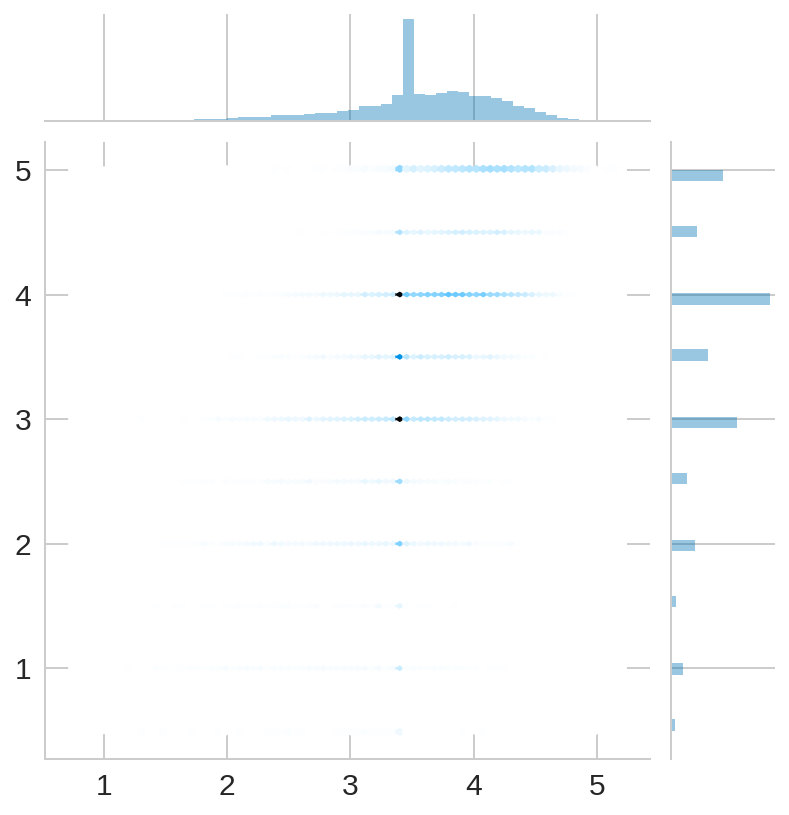

In [51]:
sns.jointplot(preds.flatten(), y_ratings.numpy(), kind='hex', stat_func=None);

# Predict movie ratings for a user

In [0]:
user_id = 42

user_data = X_test[X_test.userId == user_id]
user_ratings = y_test[user_data.index]

movie_ids = user_data.movieId

In [0]:
user_movies = movies.loc[movie_ids]
user_movies["rating"] = user_ratings.values

In [54]:
user_movies.sort_values(by=['rating'], ascending=False)

,movieId,title,genres,genre_count,year,rating
1105,1363,"Preacher's Wife, The (1996)",[Drama],1,1996,4.0
810,1006,"Chamber, The (1996)",[Drama],1,1996,4.0
344,380,True Lies (1994),"[Action, Adventure, Comedy, Romance, Thriller]",5,1994,4.0
110,122,Boomerang (1992),"[Comedy, Romance]",2,1992,4.0
3116,3902,Goya in Bordeaux (Goya en Burdeos) (1999),[Drama],1,1999,4.0
417,469,"House of the Spirits, The (1993)","[Drama, Romance]",2,1993,4.0
22,23,Assassins (1995),"[Action, Crime, Thriller]",3,1995,4.0
816,1012,Old Yeller (1957),"[Children, Drama]",2,1957,4.0
940,1181,"Shooter, The (1997)",[Western],1,1997,4.0
290,325,National Lampoon's Senior Trip (1995),[Comedy],1,1995,4.0


In [55]:
user_tensor = Variable(torch.from_numpy(user_data.values), volatile=True).cuda()

user_preds = model(user_tensor)
user_preds = user_preds.data.cpu().numpy().flatten()

pd.DataFrame(dict(predicted=user_preds, actual=user_ratings))

,actual,predicted
7251,4.0,2.737765
7144,4.0,3.397769
7209,2.0,2.978017
7162,4.0,3.428718
7178,3.0,3.402988
7201,4.0,3.603747
7215,3.0,2.985419
7200,3.0,3.727385
7217,4.0,3.827976
7167,4.0,3.514646


## Predict rating for a new movie

In [56]:
X_train.head()

,userId,movieId
37865,272,364
46342,338,113
64614,460,4626
41974,299,468
50236,368,48


In [57]:
new_movie_id = 365

movies.iloc[new_movie_id]

movieId                            415
title          Another Stakeout (1993)
genres              [Comedy, Thriller]
genre_count                          2
year                              1993
Name: 365, dtype: object

In [0]:
new_user_data = pd.concat([
    pd.DataFrame(dict(userId=[user_id], movieId=[new_movie_id])), 
    user_data]
).values

In [59]:
ut = Variable(torch.from_numpy(new_user_data), volatile=True).cuda()

up = model(ut)
up.data

RuntimeError: ignored